Author: Adrian Gonzalez

Published: 2022-01-11

Updated: 2022-01-13

Tested in Python 3.8


# Goal of this notebook

The goal of this notebook is to perform some data wrangling in order to estimate two different logit models similar to the "Logit I" and "Logit II" published on my Ph.D. Dissertation on pages 150 and 156, respectively.

The results from the published models were estimated using the "xtlogit" command from "Stata" Version 9 and here I show that it is not possible to obtain the same results with "Statsmodels" because of the panel structure of the data.  

Three new models are estimated in order to show their comparability between "Stata" and "Statsmodels".

The comparable models between "Stata" and "Statsmodels" are:

1) "Stata-logit" and "Statsmodels-Logit", 

2) "Stata-logit-robust-covariance" and "Statsmodels-Logit-robust-covariance", 

3) "Stata-clogit", "Stata-xtlogit-fe" and "Statsmodels-ConditionalLogit".

4) However, I couldn't find a model in Statsmodel equivalent to "Stata-xtlogit-re" (random effects).'

For details and specific examples for each comparison, please see models Version 1, Version 2, Version 3 and Version 4 below.


NEXT STEPS:

In a separate notebook I will find best hyperparameter for SVM, Classification Trees and Logistic Regression, and compare the scores of these models with KNN.

# Data Source and using the data

All ".dta" files used in this notebook are in "Stata" format, version 9.
The data comes from a household survey of Bolivian microfinance clients for the period 1998-2001.

You can use these ".dta files" as long as you recognize their source:
Gonzalez, Adrian (1998), "Microfinance, Incentives to REpay and Overindebtedness: Evidence from a Household Survey in Bolivia", unpublished Ph.D. Dissertation, Columbus, Ohio: The Ohio State University.

The data structure correspond to a panel for 959 households and households are identified by the variable "cuest".


# Conventions

Page references: "p. 118" = Page 118 of dissertation.

Question references:  "p36" = Question 36 of the survey.  (If you are wondering why not "q36", the survey was in Spanish and "question" in spanish is "pregunta").

# Variable names and definitions

The goal of the data wrangling is to define the  variables used in the two Logit models estimated in the dissertation.
The motivation for the use of this variables is discussed in pages 130-145 of the dissertation.

The relevant variables and their definitions are:

cuest           = Household id

fte             = Lender id

Over            = 1 if overindebted (active-30 days, active-less 30 days, inactive-less 30 days, or active 30 days or more), 0 if not overindebted               

Lazy            = 1 if inactive (less 30 days, or 30 days or more), 0 if active (0 days, less 30 days, or 30 days or more)

Cochabamba, El Alto, La Paz, Oruro, Santa Crux= dummies for each departmet

Shocks          = 1 if household experienced a shock in the 1997-2001 period

Manufacture, Commerce, Services= Dummies for main economic activity of the household

Individual, Groups, Village, Others = Dummies for type of lender

Term            = Term of the loan in years

Lenders         = Number of active loans while loan was active

Years_with_new_loans(npres97_01)= Years that received loan from lender i between 1997-2001

First_timer     = 1 if last loan was only loan received

Cohort_YYYY     = 1 if first_active_loan was in year== YYYY

Default_First   = 1 if the household will pay last when in trouble

Number_Potential_Workers(pot1460)         = Number of potential workers, 14-60 years old

Commercial      =1 if household had access to comercial lenders

Age_Main_Income_source = Age of the main source of income of the household

Education_Average = Average of years of education per worker

Diversification = Diversification index as defined on page 142

Savings         = 1 if household had liquid financial savings (including cash at home)

Migrants        = 1 if household received remitances. (Nota bene:  I should have call this variable Remitances, but I will keep the original name used in the dissertation)         



In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tools

In [2]:
from statsmodels.discrete.conditional_models import ConditionalLogit
#importing ConditionalLogit directly because there was a bug in Statsmodel version 0.13.1 

# Reading Stata Files and saving them as data frames

In [3]:
file = "C:/users/adria/downloads/over/t/acceso4 multiple sources.dta"
acceso4m = pd.read_stata(file, convert_categoricals = False)
acceso4m.to_csv("acceso4m.csv", index = False)
n = acceso4m['cuest'].nunique()
n #number of households, the number of rows can be higher because of multiple rows per household are possible

166

In [4]:
file = "C:/users/adria/downloads/over/t/acceso4 all same.dta"
acceso4a = pd.read_stata(file, convert_categoricals = False)
acceso4a.to_csv("acceso4a.csv", index = False)
n = acceso4a['cuest'].nunique()
n #number of households, the number of rows can be higher because of multiple rows per household are possible

80

In [5]:
file = "C:/users/adria/downloads/over/t/aaaregresiones5.dta"
aaaregresiones5 = pd.read_stata(file, convert_categoricals = False)
aaaregresiones5.to_csv("aaaregresiones5.csv", index = False)
n = aaaregresiones5['cuest'].nunique()
n #number of households, the number of rows can be higher because of multiple rows per household are possible

959

In [6]:
aaaregresiones5.shape

(6425, 209)

In [7]:
aaaregresiones5['choicer5'].value_counts(dropna=False) #dropna=False includes NaNs in tabulation

0    5142
1    1283
Name: choicer5, dtype: int64

In [8]:
#keeping only choicer5==1
new5=aaaregresiones5.loc[aaaregresiones5['choicer5']==1]
new5.shape

(1283, 209)

In [9]:
n = new5['cuest'].nunique()
n #number of households, the number of rows can be higher because of multiple rows per household are possible

958


# Merging dataframes

In [10]:
#left merge keeps all the rows from new5.dta
data = pd.merge(new5, acceso4m,  how='left', left_on=['cuest','fte'], right_on = ['cuest','fte'])
data.shape

(1283, 212)

In [11]:
#left merge keeps all the rows from new5.dta
data = pd.merge(data, acceso4a,  how='left', left_on=['cuest'], right_on = ['cuest'])
data.shape

(1283, 215)

In [12]:
#dropping cuest 283 because it has issues.  This row was also removed from the dataset used in the dissertation.
data.drop(data[data.cuest ==283].index, inplace=True)
data.shape

(1282, 215)

# For comparison with  Figure 8.2, p. 118

In [13]:
figure8_2=194+436+398+94+134+26
figure8_2

1282

In [14]:
data['six'].value_counts(dropna=False)

B    436
C    398
A    194
E    134
D     94
F     26
Name: six, dtype: int64

In [15]:
data['six'].value_counts().sum()

1282

In [16]:
assert data['six'].value_counts().sum()>=1282

# There are only 957 households in this dataframe as opposed to the 959 reported in the dissertation.  This is OK because of the removal of missing values

In [17]:
n = data['cuest'].nunique()
n #number of households, the number of rows can be higher because of multiple rows per household are possible

957

In [18]:
assert n>=957

# For comparison with  p. 131.

Please note that it doesn't make sense to compare with p. 110 because of the removal of missing values.

Santa Cruz 29%=382

El Alto 29%=372, 

La Paz 17%=225, 

Cochabamba: 18%=225, 

Oruro 6%=78, 

In [19]:
data[['a_Cbba', 'a_El_Alto',   'a_La_Paz',  'a_Sta_Cruz']].value_counts(dropna=False)

a_Cbba  a_El_Alto  a_La_Paz  a_Sta_Cruz
0       0          0         1             382
        1          0         0             372
        0          1         0             225
1       0          0         0             225
0       0          0         0              78
dtype: int64

In [20]:
data['a_Cbba'].value_counts(dropna=False)

0    1057
1     225
Name: a_Cbba, dtype: int64

In [21]:
data.loc[data['a_Cbba'] == 1, 'cuest_1'] = data['cuest']
CBBA = data['cuest_1'].nunique()
assert CBBA==177 #households, not rows
CBBA

177

In [22]:
data.loc[data['a_El_Alto'] == 1, 'cuest_2'] = data['cuest']
EA = data['cuest_2'].nunique()
assert EA==281 #households, not rows
EA

281

In [23]:
data.loc[data['a_La_Paz'] == 1, 'cuest_3'] = data['cuest']
LP = data['cuest_3'].nunique()
assert LP>=159 #it's ok it doesn't match p. 110
LP

159

In [24]:
data.loc[data['a_Oruro'] == 1, 'cuest_4'] = data['cuest']
OR = data['cuest_4'].nunique()
assert OR==58 #households, not rows
OR

58

In [25]:
data.loc[data['a_Sta_Cruz'] == 1, 'cuest_5'] = data['cuest']
SC = data['cuest_5'].nunique()
assert SC>=282 #it's ok it doesn't match p. 110
SC

282

In [26]:
data.drop(['cuest_1', 'cuest_2', 'cuest_3', 'cuest_4', 'cuest_5'], axis=1, inplace=True)

# New variable 'Indiferent' based on 'p54'

In [27]:
data['p54'].fillna(0, inplace=True)
data.rename(columns={"p54": "Indiferent"}, inplace=True)
data['Indiferent'].value_counts(dropna=False)

0.0    1099
1.0     183
Name: Indiferent, dtype: int64

# New variable 'Default_First' based on 'rank_inverse'

In [28]:
data[['rank_inverse', 'cuest', 'npres97_01']]

,rank_inverse,cuest,npres97_01
0,NaN,2,1
1,2.0,3,1
2,1.0,3,1
3,NaN,4,2
4,NaN,5,1
...,...,...,...
1278,5.0,966,1
1279,2.0,970,1
1280,3.0,971,1
1281,2.0,971,2


In [29]:
grouped_df = data[['rank_inverse', 'cuest']].groupby("cuest")
medianas = grouped_df.median()
medianas.rename(columns={"rank_inverse": "rank_inverse_median"}, inplace=True)

In [30]:
#left merge keeps all the rows from new5.dta
data = pd.merge(data, medianas,  how='left', left_on=['cuest'], right_on = ['cuest'])
data.shape

(1282, 216)

In [31]:
#Default_First = 1 if rank_inverse<median
data['Default_First']=(data['rank_inverse'] < data['rank_inverse_median']).astype(int)

In [32]:
data['Default_First'].value_counts(dropna=False)

0    1102
1     180
Name: Default_First, dtype: int64

# New variable 'Over' based on 'alter'.  'Over' is the 'Y' on Table 8.6, p. 150.

In [33]:
data['alter'].value_counts(dropna=False)

1    436
3    398
0    194
4    160
2     94
Name: alter, dtype: int64

In [34]:
data.loc[data.alter == 0, 'Over'] = 0
data['Over'].fillna(1, inplace=True)
data['Over'].value_counts(dropna=False)

1.0    1088
0.0     194
Name: Over, dtype: int64

In [35]:
#OVER IS NAN WHEN SIX==F
data.loc[data['six'] == 'F', 'Over'] = np.NaN

In [36]:
pd.crosstab(data['Over'], data['six'], dropna=False)

six,A,B,C,D,E,F
Over,,,,,,
0.0,194,0,0,0,0,0
1.0,0,436,398,94,134,0


In [37]:
data['Over'].value_counts(dropna=False)

1.0    1062
0.0     194
NaN      26
Name: Over, dtype: int64

# New variable 'Lazy' based on 'alter'. 'Lazy' is the 'Y" on Table 8.8, p. 156.

In [38]:
equiv = {1:0, 3:0, 2:1, 4:1}
data["Lazy"] = data["alter"].map(equiv)
pd.crosstab(data['Lazy'], data['alter'], dropna=False)

alter,0,1,2,3,4
Lazy,,,,,
0.0,0,436,0,398,0
1.0,0,0,94,0,160


In [39]:
data['Lazy'].value_counts(dropna=False)

0.0    834
1.0    254
NaN    194
Name: Lazy, dtype: int64

In [40]:
pd.crosstab(data['Lazy'], data['six'], dropna=False)

six,A,B,C,D,E,F
Lazy,,,,,,
0.0,0,436,398,0,0,0
1.0,0,0,0,94,134,26


In [41]:
#LAZY IS NAN WHEN SIX==F
data.loc[data['six'] == 'F', 'Lazy'] = np.NaN

In [42]:
pd.crosstab(data['Lazy'], data['six'], dropna=False)

six,A,B,C,D,E,F
Lazy,,,,,,
0.0,0,436,398,0,0,0
1.0,0,0,0,94,134,0


Lazy has been defined accordingly to model on Table 8.8, p. 156.

In [43]:
data['Lazy'].value_counts(dropna=False)

0.0    834
1.0    228
NaN    220
Name: Lazy, dtype: int64

# 'Oppor' based on 'altir' and 'Over'

In [44]:
data['Oppor']=0
data.loc[data['altir'] == 4, 'Oppor'] = 1
data.loc[data['Over'] == 0, 'Oppor'] = ''
pd.crosstab(data['Oppor'], data['Over'], dropna=False)

Over,0.0,1.0
Oppor,,
0,0,928
1,0,134
,194,0


In [45]:
pd.crosstab(data['Over'], data['Indiferent'], dropna=False)

Indiferent,0.0,1.0
Over,,
0.0,173,21
1.0,900,162


In [46]:
pd.crosstab(data['Over'], data['six'], dropna=False)

six,A,B,C,D,E,F
Over,,,,,,
0.0,194,0,0,0,0,0
1.0,0,436,398,94,134,0


In [47]:
pd.crosstab(data['six'], data['alter'], dropna=False)

alter,0,1,2,3,4
six,,,,,
A,194,0,0,0,0
B,0,436,0,0,0
C,0,0,0,398,0
D,0,0,94,0,0
E,0,0,0,0,134
F,0,0,0,0,26


In [48]:
data[['primero_recibida', 'ultimo_recibio', 'p36']].dtypes

primero_recibida    int16
ultimo_recibio      int16
p36                  int8
dtype: object

In [49]:
data[['primero_recibida', 'ultimo_recibio']].describe()

,primero_recibida,ultimo_recibio
count,1282.000000,1282.000000
mean,1998.344774,1999.195788
std,1.697132,1.387987
min,1995.000000,1997.000000
25%,1997.000000,1998.000000
50%,1998.000000,1999.000000
75%,2000.000000,2000.000000
max,2001.000000,2001.000000


In [50]:
data[['primero_recibida', 'ultimo_recibio', 'npres97_01', 'p36']].isna().sum()

primero_recibida    0
ultimo_recibio      0
npres97_01          0
p36                 0
dtype: int64

In [51]:
data['First_timer']=9
test=(data['First_timer'] == 9).all(axis=0)
assert test==True

# New variable 'First-timer' based on many columns

In [52]:
#First_timer 
#1 if last loan was only loan received, assume not if p36=yes, even tough years for that first loan is not reported, 
#34 cases

#p36 "Household had an active loan by January 1st, 1997"
# 1 Yes 2 No

data['First_timer']=9
data.loc[data['primero_recibida']<data['ultimo_recibio'], 'First_timer'] = 0
data.loc[data['npres97_01']>1, 'First_timer'] = 0
data.loc[(data['first_active']==data['firstever']) & (data['first_active']==data['primero_recibida']) &
         (data['first_active']==data['ultimo_recibio']) & (data['p36']==2) & (data['First_timer']==9), 'First_timer'] = 1
data.loc[(data['p36']==1) & (data['firstever']==1000) & (data['npres97_01']==1) & (data['First_timer']==9), 'First_timer'] = 0
data['First_timer'].value_counts(dropna=False)

1    816
0    466
Name: First_timer, dtype: int64

In [53]:
pd.crosstab(data['First_timer'], data['p36'], dropna=False)

p36,1,2
First_timer,,
0,112,354
1,0,816


In [54]:
data=data.reset_index(drop=False)  #need to reset index because of previous drop of 1 row
for i in range(len(data['p36'])):
    if data['p36'][i]==1 and i!=277:
        assert data['First_timer'][i]==0
print("Test OK")
print("First_timer==0 when p36==1")

Test OK
First_timer==0 when p36==1


# New variable 'Arrears' based on 'atrasos'. 
For comparisong with 3rd. paragraph on p. 113.

In [55]:
#1=Never, 2=Less than 30, 3=More than 30, 5=Rescheduled, 7=Future
data['atrasos'].value_counts(dropna=False)

1    630
2    492
3     56
5     55
7     49
Name: atrasos, dtype: int64

In [56]:
equiv = {1:1, 2:2, 3:3, 4:3, 5:3, 7:3}
data["Arrears"] = data["atrasos"].map(equiv)
#arrears 1 0 Days, 2 Less 30 Days, 3 More 30 Days
pd.crosstab(data['Arrears'], data['atrasos'], margins=True, dropna=False)

atrasos,1,2,3,5,7,All
Arrears,,,,,,
1,630,0,0,0,0,630
2,0,492,0,0,0,492
3,0,0,56,55,49,160
All,630,492,56,55,49,1282


# Recoding some dummies by type of lender

In [57]:
data['st_Groups'].value_counts(dropna=False)

0    897
1    385
Name: st_Groups, dtype: int64

In [58]:
data['st_MFOs'].value_counts(dropna=False)

0    646
1    636
Name: st_MFOs, dtype: int64

In [59]:
pd.crosstab(data['st_Groups'], data['st_MFOs'], dropna=False)

st_MFOs,0,1
st_Groups,,
0,646,251
1,0,385


In [60]:
data.rename(columns={"st_MFOs": "st_MFOs_FFPs_Indiv", "st_Groups": "st_Groups_BSOL_PRODEM", "st_VillBank": "st_Village"}, inplace=True)
data.loc[data['st_Groups_BSOL_PRODEM']==1, 'st_MFOs_FFPs_Indiv']=0
pd.crosstab(data['st_Groups_BSOL_PRODEM'], data['st_MFOs_FFPs_Indiv'], dropna=False)

st_MFOs_FFPs_Indiv,0,1
st_Groups_BSOL_PRODEM,,
0,646,251
1,385,0


In [61]:
data['st_Others']=0
data.loc[(data['tfte']!=0) & (data['tfte']!=1) & 
         (data['tfte']!=2) & (data['tfte']!=3) & (data['tfte']!=4), 'st_Others'] = 1
data.loc[(data['tfte']==3) & (data['fte']!=13) & (data['fte']!=14), 'st_Others'] = 1 #CRECER and ProMujer
data[['st_Others', 'fte', 'tfte']].loc[data['st_Others']==1]

,st_Others,fte,tfte
83,1,65,6
169,1,26,3
242,1,7,6
302,1,46,5
308,1,7,6
...,...,...,...
1270,1,47,5
1274,1,56,5
1275,1,42,5
1280,1,50,5


In [62]:
#tfte 0 Groups 1 Individual 2 Consumo 3 ONG 4 Village 5 Cooperativas 6 Banca
data.loc[data['st_Groups_BSOL_PRODEM']==1, 'tfte']=0
data.loc[data['st_Village']==1, 'tfte']=4
labels = {0:"Groups", 1:"Individual", 2:"Consumption", 3:"NGOs", 4:"Village", 5:"Coops", 6: "Banks"}
data["tfte"] = data["tfte"].map(labels)

In [63]:
data['tfte'].value_counts(dropna=False)

Groups         385
Individual     251
Consumption    242
Coops          166
Village        142
NGOs            60
Banks           36
Name: tfte, dtype: int64

In [64]:
data['tfte'].value_counts(dropna=False).sum()

1282

In [65]:
data['tfte'].value_counts(normalize=True)

Groups         0.300312
Individual     0.195788
Consumption    0.188768
Coops          0.129485
Village        0.110764
NGOs           0.046802
Banks          0.028081
Name: tfte, dtype: float64

In [66]:
data['st_MFOs_FFPs_Indiv'].value_counts(dropna=False)

0    1031
1     251
Name: st_MFOs_FFPs_Indiv, dtype: int64

In [67]:
data[['st_MFOs_FFPs_Indiv', 'st_CONS', 'st_Groups_BSOL_PRODEM', 'st_Village', 'st_Others']].value_counts(dropna=False)

st_MFOs_FFPs_Indiv  st_CONS  st_Groups_BSOL_PRODEM  st_Village  st_Others
0                   0        1                      0           0            385
                             0                      0           1            262
1                   0        0                      0           0            251
0                   1        0                      0           0            242
                    0        0                      1           0            142
dtype: int64

In [68]:
pd.crosstab(data['st_MFOs_FFPs_Indiv'], data['tfte'], dropna=False)

tfte,Banks,Consumption,Coops,Groups,Individual,NGOs,Village
st_MFOs_FFPs_Indiv,,,,,,,
0,36,242,166,385,0,60,142
1,0,0,0,0,251,0,0


In [69]:
pd.crosstab(data['st_Groups_BSOL_PRODEM'], data['tfte'], dropna=False)

tfte,Banks,Consumption,Coops,Groups,Individual,NGOs,Village
st_Groups_BSOL_PRODEM,,,,,,,
0,36,242,166,0,251,60,142
1,0,0,0,385,0,0,0


In [70]:
pd.crosstab(data['st_CONS'], data['tfte'], dropna=False)

tfte,Banks,Consumption,Coops,Groups,Individual,NGOs,Village
st_CONS,,,,,,,
0,36,0,166,385,251,60,142
1,0,242,0,0,0,0,0


In [71]:
pd.crosstab(data['st_Village'], data['tfte'], dropna=False)

tfte,Banks,Consumption,Coops,Groups,Individual,NGOs,Village
st_Village,,,,,,,
0,36,242,166,385,251,60,0
1,0,0,0,0,0,0,142


In [72]:
pd.crosstab(data['st_Others'], data['tfte'], dropna=False)

tfte,Banks,Consumption,Coops,Groups,Individual,NGOs,Village
st_Others,,,,,,,
0,0,242,0,385,251,0,142
1,36,0,166,0,0,60,0


In [73]:
data.loc[data['st_MFOs_FFPs_Indiv'] == 1, 'cuest_1'] = data['cuest']
mfos = data['cuest_1'].nunique()
assert mfos==233
mfos

233

In [74]:
data.loc[data['st_CONS'] == 1, 'cuest_2'] = data['cuest']
cons = data['cuest_2'].nunique()
assert cons==217
cons

217

In [75]:
data.loc[data['st_Groups_BSOL_PRODEM'] == 1, 'cuest_3'] = data['cuest']
groups = data['cuest_3'].nunique()
assert groups==375
groups

375

In [76]:
data.loc[data['st_Village'] == 1, 'cuest_4'] = data['cuest']
vill = data['cuest_4'].nunique()
assert vill==136
vill

136

In [77]:
data.loc[data['st_Others'] == 1, 'cuest_5'] = data['cuest']
other = data['cuest_5'].nunique()
assert other==242
other

242

In [78]:
data['exclusive']=data['st_MFOs_FFPs_Indiv']+data['st_CONS']+data['st_Groups_BSOL_PRODEM']+data['st_Village']+data['st_Others']
data[['exclusive', 'tfte', 'fte', 'st_MFOs_FFPs_Indiv','st_CONS', 'st_Groups_BSOL_PRODEM',  'st_Village', 'st_Others']].loc[data['exclusive']!=1]

,exclusive,tfte,fte,st_MFOs_FFPs_Indiv,st_CONS,st_Groups_BSOL_PRODEM,st_Village,st_Others


In [79]:
data['exclusive'].value_counts(dropna=False)

1    1282
Name: exclusive, dtype: int64

In [80]:
for i in range(len(data['exclusive'])):
    assert data['exclusive'][i]==1
print("Test OK")
print("type of lender exhaustive and mutually exclusive")

Test OK
type of lender exhaustive and mutually exclusive


In [81]:
data.drop(['cuest_1', 'cuest_2', 'cuest_3', 'cuest_4', 'cuest_5'], axis=1, inplace=True)

# Lenders Dummies match percentages on  pages 135-136.

In [82]:
lenders = data[['st_MFOs_FFPs_Indiv','st_CONS', 'st_Groups_BSOL_PRODEM',  'st_Village', 'st_Others',
                  'cuest']].groupby("cuest")
max = lenders.max()
max.describe().loc[['mean']]

,st_MFOs_FFPs_Indiv,st_CONS,st_Groups_BSOL_PRODEM,st_Village,st_Others
mean,0.243469,0.22675,0.39185,0.142111,0.252874


# For comparison with Figure 8.1, p. 115

In [83]:
pd.crosstab(data['Arrears'], data['tfte'], dropna=False, normalize='columns')

tfte,Banks,Consumption,Coops,Groups,Individual,NGOs,Village
Arrears,,,,,,,
1,0.527778,0.392562,0.403614,0.488312,0.438247,0.550000,0.830986
2,0.361111,0.388430,0.445783,0.412987,0.442231,0.333333,0.147887
3,0.111111,0.219008,0.150602,0.098701,0.119522,0.116667,0.021127


# For comparison with Figure 8.3, p. 126

In [84]:
pd.crosstab(data['six'], data['tfte'], dropna=False, normalize='columns')

tfte,Banks,Consumption,Coops,Groups,Individual,NGOs,Village
six,,,,,,,
A,0.166667,0.136364,0.162651,0.129870,0.139442,0.216667,0.211268
B,0.361111,0.256198,0.240964,0.358442,0.298805,0.333333,0.619718
C,0.305556,0.272727,0.349398,0.358442,0.358566,0.283333,0.126761
D,0.055556,0.115702,0.096386,0.054545,0.083665,0.050000,0.021127
E,0.111111,0.198347,0.108434,0.085714,0.091633,0.116667,0.007042
F,0.000000,0.020661,0.042169,0.012987,0.027888,0.000000,0.014085


# Renames to match variable names used on p. 150 and p. 156.

In [85]:
data.rename(columns={"plazo": "Loan_Term"}, inplace=True)
data.rename(columns={"pot1460": "Number_Potential_Workers"}, inplace=True)
data.rename(columns={"p4pp": "Age_Main_Income_Source"}, inplace=True)
data.rename(columns={"eworkers1460": "Education_Average"}, inplace=True)

# Economic Activity, for comparison with text after table 8.3, p. 134.

In [86]:
#Services
data.loc[data['Services'] == 1, 'ss'] = data['cuest']
ss = data['ss'].nunique()
assert ss==446
ss=ss/959
ss

0.46506777893639206

In [87]:
#Commmerce
data.loc[data['Commerce'] == 1, 'cc'] = data['cuest']
cc = data['cc'].nunique()
assert cc==188
cc=cc/959
cc

0.19603753910323254

In [88]:
#Manufacturing
data.loc[data['Manufacture'] == 1, 'mm'] = data['cuest']
mm = data['mm'].nunique()
assert mm==102
mm=mm/959
mm

0.10636079249217935

# Shocks, for comparison with Table 8.3, p. 134

In [89]:
shocks_df = data[['Shocks', 
                  'Shocks_97', 'Shocks_98', 'Shocks_99', 'Shocks_00', 'Shocks_01', 
                  'shock_before_loan_98', 'shock_before_loan_99','shock_before_loan_00','shock_before_loan_01',
                  'cuest']].groupby("cuest")
means = shocks_df.mean()
means.describe().loc[['mean']]

,Shocks,Shocks_97,Shocks_98,Shocks_99,Shocks_00,Shocks_01,shock_before_loan_98,shock_before_loan_99,shock_before_loan_00,shock_before_loan_01
mean,0.687252,0.047283,0.087948,0.186712,0.347962,0.412313,0.052232,0.036953,0.064911,0.094062


# 'Loan_Term' for comparison with p. 136

In [90]:
data['Loan_Term'].describe().loc[['mean']]

mean    1.608158
Name: Loan_Term, dtype: float64

# For comparison with Table 8.4, p. 141. 1st and 3rd rows.

In [91]:
t84 = data[['Lenders','a97','a98','a99','a00','a01', 
      'Coh_97', 'Coh_98', 'Coh_99', 'Coh_00', 'Coh_01',
                  'cuest']].groupby("cuest")
t84.mean().describe().loc[['mean']]

,Lenders,a97,a98,a99,a00,a01,Coh_97,Coh_98,Coh_99,Coh_00,Coh_01
mean,1.239168,0.249094,0.436886,0.549286,0.589063,0.542894,0.249094,0.245367,0.211181,0.176385,0.117973


In [92]:
t84['Lenders'].mean().value_counts(dropna=False, normalize=True)

1.000000    0.799373
2.000000    0.154650
3.000000    0.024033
1.666667    0.008359
2.500000    0.003135
4.000000    0.003135
2.600000    0.001045
1.500000    0.001045
5.000000    0.001045
2.750000    0.001045
1.800000    0.001045
3.400000    0.001045
6.000000    0.001045
Name: Lenders, dtype: float64

# For comparisong with Table 8.4, p. 141. 2nd row.

In [93]:
#averages of a97-a01, but only for active borrowers
years = ["97", "98", "99", "00", "01"]
for i in years:
    col='a'+i
    temp=data.loc[data[col]==1]
    temp2 = temp[[col,'cuest']].groupby("cuest")
    print(temp2.sum().describe().loc[['mean']])

           a97
mean  1.108108
           a98
mean  1.179541
           a99
mean  1.187817
           a00
mean  1.191626
           a01
mean  1.171821


In [94]:
data[['First_timer', 'Default_First']].describe().loc[['mean']] 

,First_timer,Default_First
mean,0.636505,0.140406


# 'Lenders'

In [95]:
data.shape

(1282, 228)

In [96]:
data['Lenders'].describe().loc[['mean']] 

mean    1.471919
Name: Lenders, dtype: float64

In [97]:
data['Lenders'].value_counts(dropna=False, normalize=True)

1    0.654446
2    0.254290
3    0.069423
4    0.013261
6    0.004680
5    0.003900
Name: Lenders, dtype: float64

In [98]:
t9 = data[['Lenders_97', 'Lenders_98','Lenders_99','Lenders_00','Lenders_01',
                'i97','i98','i99','i00','i01',
                'cuest']].groupby("cuest")
t9.sum().describe().loc[['mean']]

,Lenders_97,Lenders_98,Lenders_99,Lenders_00,Lenders_01,i97,i98,i99,i00,i01
mean,0.417973,0.820272,1.015674,1.07419,0.956113,0.342738,0.438871,0.460815,0.412748,0.320794


# 'npres97_01' for comparison with 2nd paragraph, p. 138.

In [99]:
data['npres97_01'].describe().loc[['mean']] 

mean    1.475039
Name: npres97_01, dtype: float64

In [100]:
data['npres97_01'].value_counts(dropna=False, normalize=True)

1    0.737129
2    0.133385
3    0.074103
4    0.028081
5    0.027301
Name: npres97_01, dtype: float64

# New variable 'Migrants' based on 'p105'

In [101]:
data['p105'].value_counts(dropna=False)

2    1091
1     185
9       4
3       2
Name: p105, dtype: int64

In [102]:
data.loc[data['p105'] == 1, 'Migrants'] = 1
data['Migrants'].fillna(0, inplace=True)
data['Migrants'].value_counts(dropna=False)

0.0    1097
1.0     185
Name: Migrants, dtype: int64

# Keeps only Y and X, and 'cuest' for estimation of robust covariance matrix


In [103]:
data_reduced=data.loc[:,['Lazy', 'Over', 'six',
        'a_Cbba', 'a_El_Alto', 'a_La_Paz', 'a_Oruro', 'a_Sta_Cruz',
        'Shocks',
        'Manufacture', 'Commerce', 'Services',
        'st_MFOs_FFPs_Indiv','st_CONS', 'st_Groups_BSOL_PRODEM',  'st_Village', 'st_Others',
        'Loan_Term', 'Lenders', 'npres97_01','First_timer',
        'Coh_97', 'Coh_98', 'Coh_99', 'Coh_00',
        'Default_First', 
        'Number_Potential_Workers', 'Age_Main_Income_Source', 'Education_Average', 'Diversification','Savings','Migrants',
        'Female_Main_Person',
        'Commercial',  'Assets',
         'cruzados',
        'Shocks_97','Shocks_98','Shocks_99','Shocks_00','Shocks_01', 
        'cuest'
]]

Final rename to make sure all variables have the same name as in Table 8.6, p. 150

In [104]:
data_reduced.rename(columns={"a_Cbba": "Cochabamba", "a_El_Alto": "El_Alto", "a_La_Paz": "La_Paz", "a_Oruro": "Oruro", "a_Sta_Cruz": "Santa_Cruz",
                     "st_MFOs_FFPs_Indiv": "Individual", "st_Groups_BSOL_PRODEM": "Groups", "st_Village": "Village",
                     "st_Others" : "Others", "st_CONS": "Consumption",
                     "npres97_01": "Years_with_new_loans",
                     "Coh_97": "Cohort_1997", "Coh_98": "Cohort_1998", "Coh_99": "Cohort_1999", "Coh_00": "Cohort_2000"}, inplace=True)
data_reduced.head()

,Lazy,Over,six,Cochabamba,El_Alto,La_Paz,Oruro,Santa_Cruz,Shocks,Manufacture,...,Female_Main_Person,Commercial,Assets,cruzados,Shocks_97,Shocks_98,Shocks_99,Shocks_00,Shocks_01,cuest
0,0.0,1.0,B,0,0,1,0,0,1,0,...,0,0,1.139501,0,0,0,0,0,1,2
1,0.0,1.0,B,0,0,1,0,0,1,0,...,1,0,0.080764,0,1,1,0,0,0,3
2,0.0,1.0,C,0,0,1,0,0,1,0,...,1,0,0.080764,1,1,1,1,1,0,3
3,0.0,1.0,C,0,0,1,0,0,1,0,...,0,0,1.294317,0,0,0,0,1,0,4
4,NaN,0.0,A,0,0,1,0,0,1,0,...,1,0,0.409985,0,0,0,1,0,0,5


# DATAFRAME FOR LOGIT I

In [105]:
xs1=['Cochabamba', 'El_Alto', 'La_Paz', 'Oruro',
        'Shocks',
        'Manufacture', 'Commerce', 'Services',
        'Individual', 'Groups',  'Village', 'Others',
        'Loan_Term', 'Lenders','Years_with_new_loans',
        'Cohort_1997', 'Cohort_1998', 'Cohort_1999', 'Cohort_2000',
        'Commercial',
        'Age_Main_Income_Source', 'Education_Average']

In [106]:
vars1=['Over']+xs1+['cuest']

In [107]:
data1=data_reduced[vars1]
data1.shape

(1282, 24)

In [108]:
data1['Over'].value_counts(dropna=False)

1.0    1062
0.0     194
NaN      26
Name: Over, dtype: int64

In [109]:
data1.isna().sum() #In this notebook I will drop missing rows following the dissertation methodology

Over                      26
Cochabamba                 0
El_Alto                    0
La_Paz                     0
Oruro                      0
Shocks                     0
Manufacture                0
Commerce                   0
Services                   0
Individual                 0
Groups                     0
Village                    0
Others                     0
Loan_Term                 10
Lenders                    0
Years_with_new_loans       0
Cohort_1997                0
Cohort_1998                0
Cohort_1999                0
Cohort_2000                0
Commercial                 0
Age_Main_Income_Source     3
Education_Average         11
cuest                      0
dtype: int64

In [110]:
data1.dropna(axis=0, inplace=True)
data1.shape

C:\Users\adria\anaconda3\envs\Python38forstatsmodels\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


(1236, 24)

In [111]:
Y1=data1['Over']
Y1.to_csv("dataY1.csv", index = False)
Y1.value_counts(dropna=False)

1.0    1048
0.0     188
Name: Over, dtype: int64

In [112]:
X1=data1[xs1]
X1=statsmodels.tools.tools.add_constant(X1, prepend=False) #False, set constant to last column, True first column
X1.to_csv("dataX1.csv", index = False)

# Logit I - Version 1 - simple logit

This model was estimated only to show that the same results can be obtained with the "logit" command in Stata.
However, the standard errors in this model do not take into account the panel structure of the data.
This is known sometimes as a "pooled logit".

In [113]:
model1 = sm.Logit(Y1,X1)
result1 = model1.fit(full_output=True, disp=True, tol=0.0000000001)
result1.summary()

Optimization terminated successfully.
         Current function value: 0.390905
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Over   No. Observations:                 1236
Model:                          Logit   Df Residuals:                     1213
Method:                           MLE   Df Model:                           22
Date:                Thu, 13 Jan 2022   Pseudo R-squ.:                 0.08312
Time:                        11:21:07   Log-Likelihood:                -483.16
converged:                       True   LL-Null:                       -526.96
Covariance Type:            nonrobust   LLR p-value:                 8.758e-10
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Cochabamba                 0.3152      0.252      1.252      0.211      -0.178       0.809
El_Alto                    0.4535      0.244      1.862      0.063      -0.024       0.931
La_Paz                     0.7075      0.299      2.363      0.018       0.121       1.294
Oruro                      0.8817      0.407      2.164      0.030       0.083       1.680
Shocks                     0.8040      0.192      4.177      0.000       0.427       1.181
Manufacture               -0.4750      0.301     -1.579      0.114      -1.065       0.115
Commerce                   0.0543      0.270      0.201      0.841      -0.475       0.583
Services                  -0.0396      0.218     -0.181      0.856      -0.468       0.389
Individual                 0.1402      0.303      0.463      0.643      -0.453       0.733
Groups                     0.1404      0.270      0.520      0.603      -0.389       0.670
Village                   -0.0639      0.343     -0.186      0.852      -0.736       0.608
Others                    -0.2010      0.266     -0.754      0.451      -0.723       0.321
Loan_Term                  0.1106      0.061      1.805      0.071      -0.009       0.231
Lenders                   -0.0085      0.112     -0.076      0.939      -0.227       0.210
Years_with_new_loans      -0.3752      0.104     -3.611      0.000      -0.579      -0.172
Cohort_1997                1.8354      0.326      5.635      0.000       1.197       2.474
Cohort_1998                1.3395      0.285      4.695      0.000       0.780       1.899
Cohort_1999                1.2087      0.281      4.300      0.000       0.658       1.760
Cohort_2000                0.8864      0.274      3.235      0.001       0.349       1.423
Commercial                 0.8275      0.237      3.487      0.000       0.362       1.293
Age_Main_Income_Source    -0.0074      0.008     -0.934      0.350      -0.023       0.008
Education_Average         -0.0514      0.025     -2.053      0.040      -0.101      -0.002
const                      0.8016      0.555      1.443      0.149      -0.287       1.890
==========================================================================================
"""

Equivalent output from Stata 17 after running the following line:
    
logit Over a_* Shocks Manufacture Commerce Services st_MFO st_Groups st_V  st_Others Term Lenders npres97 Coh_97-Coh_00 Commercial Age Education  ,  nolog 


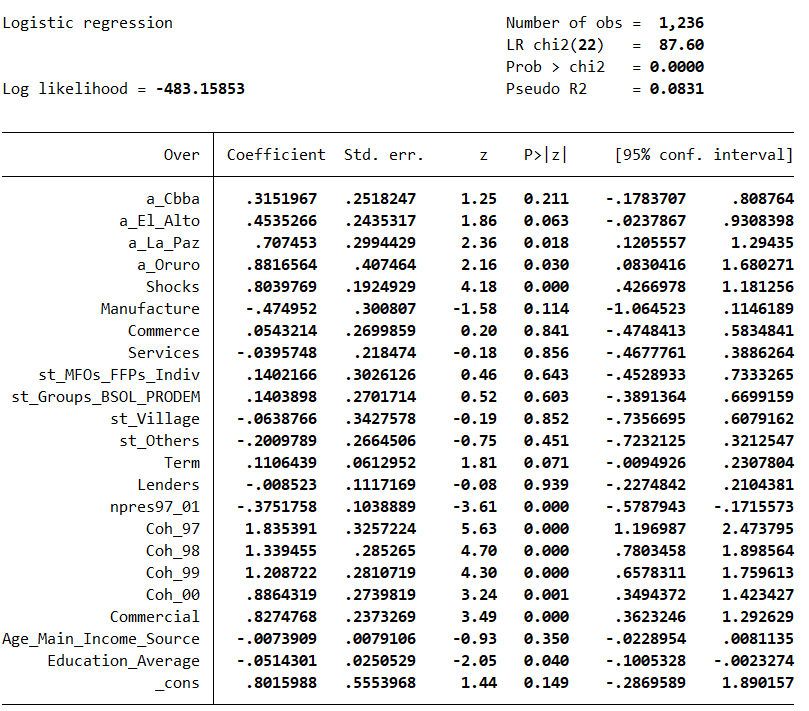

# Logit I - Version 2 - Logit with clustered covariance

This model was estimated only to show that similar results can be obtained with the "logit, options: vce(cluster cuest)" in "Stata".
However, these results do not take into account correctly the panel structure of the data.

In [114]:
mygroups=data1['cuest'] #cluesters for robust covariance matrix
result1 = model1.fit(full_output=True, disp=True, tol=0.0000000001, cov_type='cluster', cov_kwds={'groups': mygroups})
result1.summary()

Optimization terminated successfully.
         Current function value: 0.390905
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Over   No. Observations:                 1236
Model:                          Logit   Df Residuals:                     1213
Method:                           MLE   Df Model:                           22
Date:                Thu, 13 Jan 2022   Pseudo R-squ.:                 0.08312
Time:                        11:21:07   Log-Likelihood:                -483.16
converged:                       True   LL-Null:                       -526.96
Covariance Type:              cluster   LLR p-value:                 8.758e-10
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Cochabamba                 0.3152      0.272      1.161      0.246      -0.217       0.847
El_Alto                    0.4535      0.279      1.625      0.104      -0.093       1.000
La_Paz                     0.7075      0.349      2.027      0.043       0.023       1.392
Oruro                      0.8817      0.435      2.026      0.043       0.029       1.735
Shocks                     0.8040      0.204      3.941      0.000       0.404       1.204
Manufacture               -0.4750      0.325     -1.460      0.144      -1.112       0.163
Commerce                   0.0543      0.290      0.188      0.851      -0.513       0.622
Services                  -0.0396      0.248     -0.159      0.873      -0.526       0.447
Individual                 0.1402      0.330      0.425      0.671      -0.506       0.786
Groups                     0.1404      0.296      0.475      0.635      -0.439       0.720
Village                   -0.0639      0.395     -0.162      0.872      -0.839       0.711
Others                    -0.2010      0.273     -0.736      0.462      -0.736       0.334
Loan_Term                  0.1106      0.103      1.078      0.281      -0.090       0.312
Lenders                   -0.0085      0.143     -0.060      0.952      -0.288       0.271
Years_with_new_loans      -0.3752      0.104     -3.623      0.000      -0.578      -0.172
Cohort_1997                1.8354      0.338      5.431      0.000       1.173       2.498
Cohort_1998                1.3395      0.302      4.441      0.000       0.748       1.931
Cohort_1999                1.2087      0.292      4.142      0.000       0.637       1.781
Cohort_2000                0.8864      0.288      3.078      0.002       0.322       1.451
Commercial                 0.8275      0.271      3.051      0.002       0.296       1.359
Age_Main_Income_Source    -0.0074      0.008     -0.935      0.350      -0.023       0.008
Education_Average         -0.0514      0.025     -2.031      0.042      -0.101      -0.002
const                      0.8016      0.562      1.426      0.154      -0.301       1.904
==========================================================================================
"""

Equivalent output from Stata 17 after running the following line:
    
logit Over a_* Shocks Manufacture Commerce Services st_MFO st_Groups st_V  st_Others Term Lenders npres97 Coh_97-Coh_00 Commercial Age Education  ,  log vce(cluster cuest) 


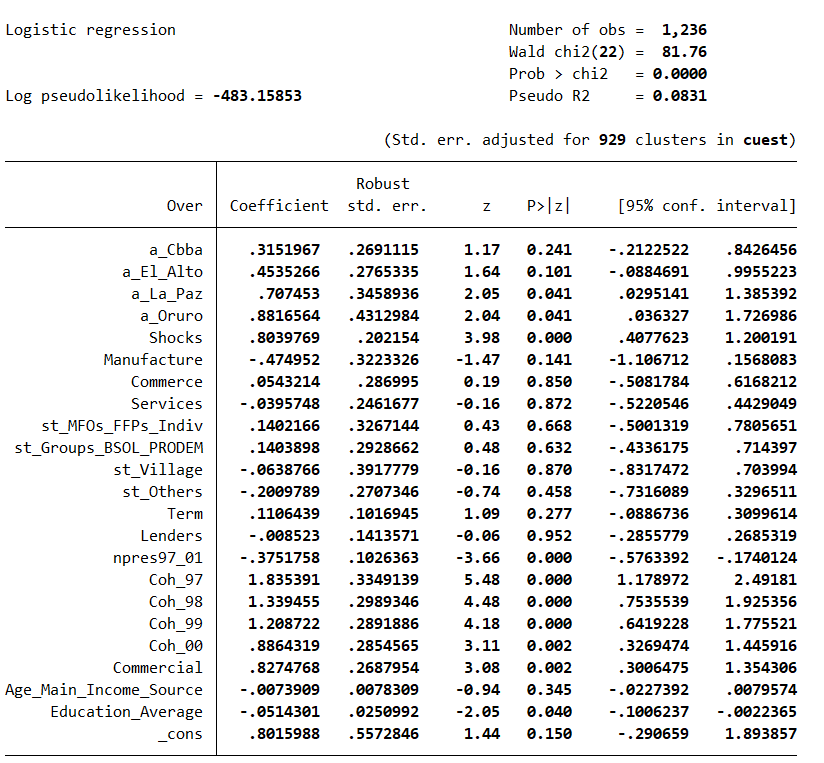

# Logit I - Version 3 - ConditionalLogit

In [115]:
#dropping all variables with "no within-group variance"
X1.drop(['const', 'Cochabamba', 'El_Alto', 'La_Paz', 'Oruro',
        'Manufacture', 'Commerce', 'Services',
        'Commercial',
        'Age_Main_Income_Source', 'Education_Average'
        ], axis=1, inplace=True)

In [116]:
model11 = ConditionalLogit(Y1, X1, groups = mygroups)
result11 = model11.fit(full_output=True, disp=True, maxiter=500)
result11.summary()

C:\Users\adria\anaconda3\envs\Python38forstatsmodels\lib\site-packages\statsmodels\discrete\conditional_models.py:80: UserWarning: Dropped 887 groups and 1127 observations for having no within-group variance
  warnings.warn(msg)


Optimization terminated successfully.
         Current function value: 0.010668
         Iterations: 137
         Function evaluations: 139
         Gradient evaluations: 139


<class 'statsmodels.iolib.summary.Summary'>
"""
                  Conditional Logit Model Regression Results                  
==============================================================================
Dep. Variable:                   Over   No. Observations:                  109
Model:               ConditionalLogit   No. groups:                         42
Log-Likelihood:               -13.186   Min group size:                      2
Method:                          BFGS   Max group size:                      5
Date:                Thu, 13 Jan 2022   Mean group size:                   2.6
Time:                        11:21:07                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Shocks                  -2.7467      1.622     -1.693      0.090      -5.926       0.433
Individual               0.8955      1.150      0.778      0.436      -1.359       3.150
Groups                   4.9269      1.983      2.485      0.013       1.041       8.813
Village                  2.9369      1.857      1.581      0.114      -0.703       6.577
Others                   0.0686      1.079      0.064      0.949      -2.047       2.184
Loan_Term                1.9461      0.753      2.585      0.010       0.470       3.422
Lenders                  8.9832     10.028      0.896      0.370     -10.672      28.638
Years_with_new_loans    -0.6091      0.738     -0.825      0.409      -2.056       0.838
Cohort_1997              6.2055      2.552      2.432      0.015       1.204      11.207
Cohort_1998              2.2865      1.976      1.157      0.247      -1.587       6.160
Cohort_1999              4.2643      2.184      1.952      0.051      -0.017       8.545
Cohort_2000              3.3816      2.213      1.528      0.127      -0.956       7.720
========================================================================================
"""

Comparable version from Stata using xtlogit fe or conditional logit: 

1) clogit Over a_* Shocks Manufacture Commerce Services st_MFO st_Groups st_V  st_Others Term Lenders npres97 Coh_97-Coh_00 Commercial  Age Education  ,  nolog group(cuest) 

2)xtlogit Over a_* Shocks Manufacture Commerce Services st_MFO st_Groups st_V  st_Others Term Lenders npres97 Coh_97-Coh_00 Commercial  Age Education  ,  nolog i(cuest) fe

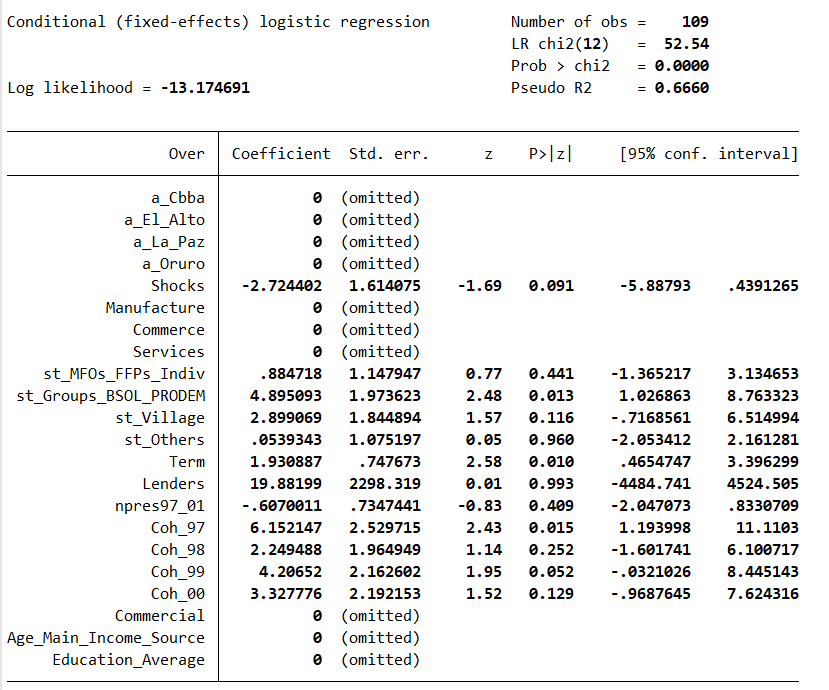

# Logit I - Version 4 equivalent to Table 8.6, p. 150

These are the results from Stata using "xtlogit".  xtlogit takes into account correcly the panel structure of the data and therefore, the results below are the best estimates for the coefficients and standard errors of the data.

These results were obtained after running the following line:
version 9: xtlogit Over a_* Shocks Manufacture Commerce Services st_MFO st_Groups st_V  st_Others Term Lenders npres97 Coh_97-Coh_00 Commercial  Age Education  ,  nolog i(cuest) re


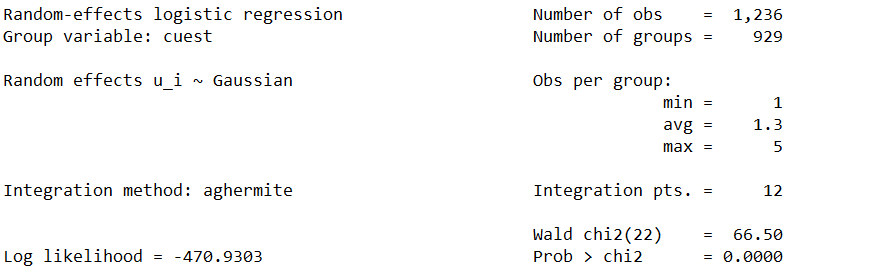

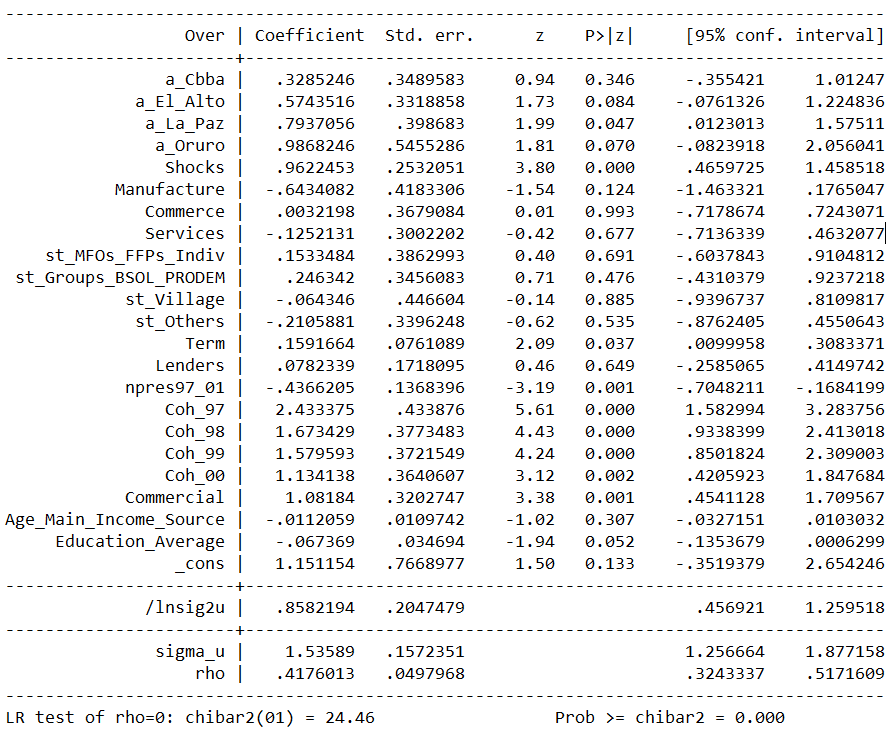

# DATAFRAME FOR LOGIT II

In [117]:
xs2=['Cochabamba', 'El_Alto', 'La_Paz', 'Santa_Cruz',
        'Shocks',
        'Manufacture', 'Commerce', 'Services',
        'Individual','Consumption', 'Groups',  'Others',
        'Loan_Term', 'Lenders', 'First_timer',
        'Cohort_1997', 'Cohort_1998', 'Cohort_1999', 'Cohort_2000',
        'Default_First', 
        'Number_Potential_Workers', 'Age_Main_Income_Source', 'Education_Average', 'Diversification','Savings','Migrants'
       ]
vars2=['Lazy']+xs2+['cuest']
data2=data_reduced[vars2]
data2.shape

(1282, 28)

In [118]:
data2['Lazy'].value_counts(dropna=False)

0.0    834
1.0    228
NaN    220
Name: Lazy, dtype: int64

In [119]:
data2.isna().sum()

Lazy                        220
Cochabamba                    0
El_Alto                       0
La_Paz                        0
Santa_Cruz                    0
Shocks                        0
Manufacture                   0
Commerce                      0
Services                      0
Individual                    0
Consumption                   0
Groups                        0
Others                        0
Loan_Term                    10
Lenders                       0
First_timer                   0
Cohort_1997                   0
Cohort_1998                   0
Cohort_1999                   0
Cohort_2000                   0
Default_First                 0
Number_Potential_Workers      0
Age_Main_Income_Source        3
Education_Average            11
Diversification               0
Savings                       0
Migrants                      0
cuest                         0
dtype: int64

In [120]:
data2.dropna(axis=0, inplace=True)
data2.shape

C:\Users\adria\anaconda3\envs\Python38forstatsmodels\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


(1048, 28)

In [121]:
Y2=data2['Lazy']
Y2.to_csv("dataY2.csv", index = False)
Y2.value_counts(dropna=False)

0.0    822
1.0    226
Name: Lazy, dtype: int64

In [122]:
X2=data2[xs2]
X2=statsmodels.tools.tools.add_constant(X2, prepend=False) #False, set constant to last column, True first column
X2.to_csv("dataX2.csv", index = False)

# Logit II - Version 1.  Simple logit

Please see comments under Logit I - Version 1 before.

In [123]:
model2 = sm.Logit(Y2,X2)
result2 = model2.fit(full_output=True, disp=True, tol=0.0000000001)
result2.summary()

Optimization terminated successfully.
         Current function value: 0.462384
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Lazy   No. Observations:                 1048
Model:                          Logit   Df Residuals:                     1021
Method:                           MLE   Df Model:                           26
Date:                Thu, 13 Jan 2022   Pseudo R-squ.:                  0.1131
Time:                        11:21:07   Log-Likelihood:                -484.58
converged:                       True   LL-Null:                       -546.37
Covariance Type:            nonrobust   LLR p-value:                 1.166e-14
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Cochabamba                  -1.7373      0.355     -4.892      0.000      -2.433      -1.041
El_Alto                     -1.7050      0.327     -5.212      0.000      -2.346      -1.064
La_Paz                      -1.3732      0.332     -4.141      0.000      -2.023      -0.723
Santa_Cruz                  -1.1351      0.316     -3.586      0.000      -1.755      -0.515
Shocks                       0.0506      0.192      0.263      0.793      -0.327       0.428
Manufacture                  0.3093      0.289      1.069      0.285      -0.258       0.877
Commerce                    -0.0970      0.250     -0.387      0.698      -0.588       0.394
Services                    -0.0258      0.207     -0.125      0.901      -0.432       0.380
Individual                   1.5334      0.562      2.728      0.006       0.432       2.635
Consumption                  2.2464      0.572      3.930      0.000       1.126       3.367
Groups                       1.1181      0.554      2.017      0.044       0.031       2.205
Others                       1.5241      0.578      2.636      0.008       0.391       2.657
Loan_Term                    0.0365      0.045      0.805      0.421      -0.052       0.125
Lenders                      0.0540      0.115      0.468      0.640      -0.172       0.280
First_timer                 -0.0638      0.190     -0.336      0.737      -0.436       0.308
Cohort_1997                  0.8693      0.402      2.160      0.031       0.080       1.658
Cohort_1998                  0.7846      0.390      2.010      0.044       0.019       1.550
Cohort_1999                  0.7529      0.393      1.915      0.055      -0.018       1.524
Cohort_2000                  0.4280      0.420      1.018      0.309      -0.396       1.252
Default_First                0.6958      0.225      3.088      0.002       0.254       1.138
Number_Potential_Workers     0.0203      0.052      0.391      0.696      -0.082       0.122
Age_Main_Income_Source       0.0056      0.009      0.653      0.514      -0.011       0.022
Education_Average            0.0166      0.024      0.679      0.497      -0.031       0.065
Diversification             -0.0425      0.117     -0.363      0.717      -0.272       0.187
Savings                      0.0363      0.174      0.209      0.834      -0.304       0.377
Migrants                    -0.0650      0.238     -0.273      0.785      -0.531       0.401
const                       -2.8190      0.840     -3.354      0.001      -4.466      -1.172
============================================================================================
"""

Equivalent output from Stata 17 after running the following line:
    
logit Lazy  a_Cbba a_El_Alto a_La_Paz a_Sta_Cruz Shocks Manufacture Commerce Services st_MFO st_CONS st_Groups  st_Others Term Lenders First_timer Coh_97-Coh_00 Default_First  Pot1460 Age  Education Diver Sav*  Migrants	 ,  nolog

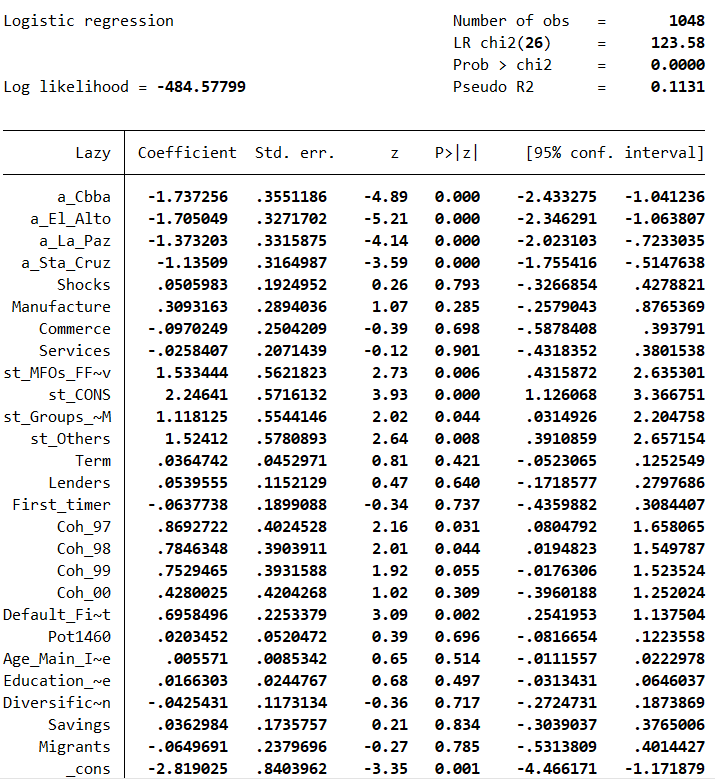

# Logit II - Version 2 - Logit with clustered covariance matrix

Please see comments under Logit I - Version 2 before.

In [124]:
model2 = sm.Logit(Y2,X2, missing= 'drop')
mygroups=data2['cuest'] #clusters for robust covariance matrix
result2 = model2.fit(full_output=True, disp=True, tol=0.0000000001, cov_type='cluster', cov_kwds={'groups': mygroups})
result2.summary()

Optimization terminated successfully.
         Current function value: 0.462384
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Lazy   No. Observations:                 1048
Model:                          Logit   Df Residuals:                     1021
Method:                           MLE   Df Model:                           26
Date:                Thu, 13 Jan 2022   Pseudo R-squ.:                  0.1131
Time:                        11:21:07   Log-Likelihood:                -484.58
converged:                       True   LL-Null:                       -546.37
Covariance Type:              cluster   LLR p-value:                 1.166e-14
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Cochabamba                  -1.7373      0.369     -4.714      0.000      -2.460      -1.015
El_Alto                     -1.7050      0.341     -5.000      0.000      -2.373      -1.037
La_Paz                      -1.3732      0.356     -3.860      0.000      -2.070      -0.676
Santa_Cruz                  -1.1351      0.330     -3.441      0.001      -1.782      -0.489
Shocks                       0.0506      0.197      0.257      0.797      -0.335       0.436
Manufacture                  0.3093      0.285      1.086      0.278      -0.249       0.868
Commerce                    -0.0970      0.279     -0.347      0.728      -0.645       0.451
Services                    -0.0258      0.219     -0.118      0.906      -0.454       0.403
Individual                   1.5334      0.563      2.723      0.006       0.430       2.637
Consumption                  2.2464      0.572      3.925      0.000       1.125       3.368
Groups                       1.1181      0.563      1.985      0.047       0.014       2.222
Others                       1.5241      0.581      2.623      0.009       0.385       2.663
Loan_Term                    0.0365      0.047      0.780      0.436      -0.055       0.128
Lenders                      0.0540      0.112      0.482      0.630      -0.165       0.273
First_timer                 -0.0638      0.193     -0.331      0.741      -0.442       0.314
Cohort_1997                  0.8693      0.406      2.139      0.032       0.073       1.666
Cohort_1998                  0.7846      0.388      2.023      0.043       0.024       1.545
Cohort_1999                  0.7529      0.408      1.846      0.065      -0.046       1.552
Cohort_2000                  0.4280      0.423      1.012      0.312      -0.401       1.257
Default_First                0.6958      0.217      3.210      0.001       0.271       1.121
Number_Potential_Workers     0.0203      0.053      0.387      0.698      -0.083       0.123
Age_Main_Income_Source       0.0056      0.009      0.628      0.530      -0.012       0.023
Education_Average            0.0166      0.027      0.624      0.533      -0.036       0.069
Diversification             -0.0425      0.118     -0.359      0.719      -0.275       0.189
Savings                      0.0363      0.183      0.199      0.842      -0.321       0.394
Migrants                    -0.0650      0.253     -0.257      0.797      -0.561       0.431
const                       -2.8190      0.793     -3.556      0.000      -4.373      -1.265
============================================================================================
"""

Equivalent output from Stata 17 after running the following line:
    
logit Lazy  a_Cbba a_El_Alto a_La_Paz a_Sta_Cruz Shocks Manufacture Commerce Services st_MFO st_CONS st_Groups  st_Others Term Lenders First_timer Coh_97-Coh_00 Default_First  Pot1460 Age  Education Diver Sav*  Migrants	 ,  nolog vce(cluster cuest) 

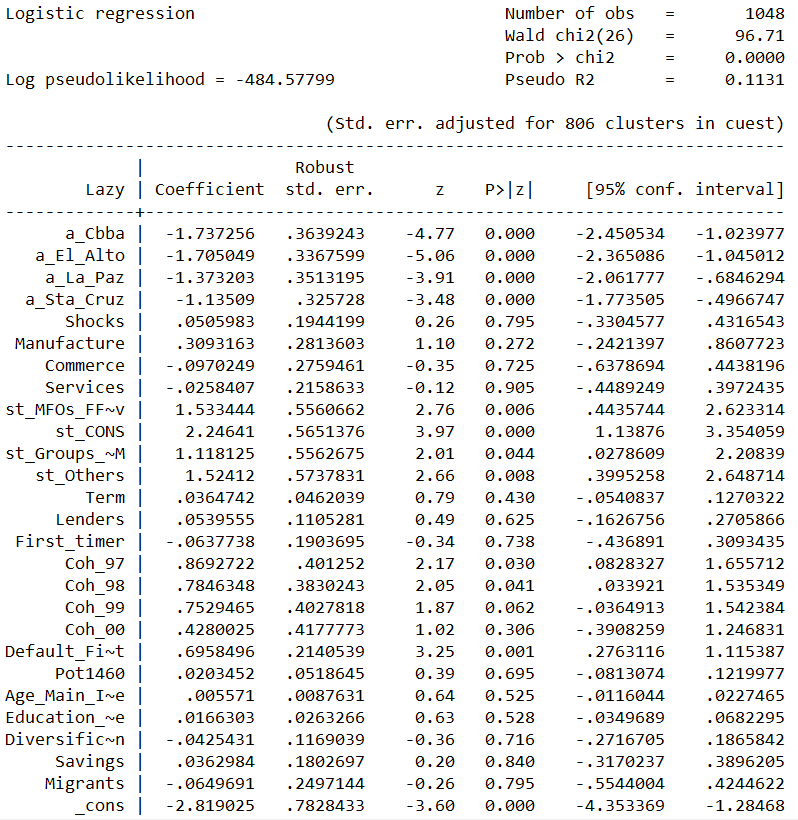

# Logit II - Version 3 - using ConditionalLogit

In [125]:
#dropping all variables with "no within-group variance"
X2.drop(['const', 'Cochabamba', 'El_Alto', 'La_Paz', 'Santa_Cruz',
        'Manufacture', 'Commerce', 'Services',
        'Number_Potential_Workers','Age_Main_Income_Source', 'Education_Average', 'Savings','Migrants'
        ], axis=1, inplace=True)

In [126]:
model22 = ConditionalLogit(Y2, X2, groups = mygroups)
result22 = model22.fit(full_output=True, disp=True, maxiter=500)
result22.summary()

C:\Users\adria\anaconda3\envs\Python38forstatsmodels\lib\site-packages\statsmodels\discrete\conditional_models.py:80: UserWarning: Dropped 748 groups and 904 observations for having no within-group variance
  warnings.warn(msg)


Optimization terminated successfully.
         Current function value: 0.032805
         Iterations: 136
         Function evaluations: 138
         Gradient evaluations: 138


<class 'statsmodels.iolib.summary.Summary'>
"""
                  Conditional Logit Model Regression Results                  
==============================================================================
Dep. Variable:                   Lazy   No. Observations:                  144
Model:               ConditionalLogit   No. groups:                         58
Log-Likelihood:               -34.379   Min group size:                      2
Method:                          BFGS   Max group size:                      5
Date:                Thu, 13 Jan 2022   Mean group size:                   2.5
Time:                        11:21:08                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Shocks              1.4334      0.880      1.629      0.103      -0.292       3.158
Individual          3.3345      1.499      2.225      0.026       0.397       6.272
Consumption         4.3219      1.578      2.739      0.006       1.229       7.415
Groups              2.1678      1.429      1.517      0.129      -0.633       4.969
Others              4.4892      1.672      2.685      0.007       1.213       7.766
Loan_Term          -0.5054      0.214     -2.364      0.018      -0.924      -0.086
Lenders             0.3208      1.224      0.262      0.793      -2.078       2.719
First_timer        -0.0129      0.638     -0.020      0.984      -1.263       1.237
Cohort_1997         2.7564      1.156      2.383      0.017       0.490       5.023
Cohort_1998         2.3246      0.969      2.398      0.016       0.425       4.224
Cohort_1999         1.5618      0.965      1.618      0.106      -0.330       3.453
Cohort_2000         2.2246      1.231      1.807      0.071      -0.189       4.638
Default_First       0.4395      0.416      1.056      0.291      -0.376       1.255
Diversification     0.7582      1.123      0.675      0.500      -1.443       2.959
===================================================================================
"""

Comparable version from Stata using xtlogit fe or conditional clogit: 

1) clogit Lazy  a_Cbba a_El_Alto a_La_Paz a_Sta_Cruz Shocks Manufacture Commerce Services st_MFO st_CONS st_Groups  st_Others Term Lenders First_timer Coh_97-Coh_00 Default_First  Pot1460 Age  Education Diver Sav*  Migrants ,  nolog group(cuest) 

2) xtlogit Lazy  a_Cbba a_El_Alto a_La_Paz a_Sta_Cruz Shocks Manufacture Commerce Services st_MFO st_CONS st_Groups  st_Others Term Lenders First_timer Coh_97-Coh_00 Default_First  Pot1460 Age  Education Diver Sav*  Migrants,  nolog i(cuest) fe

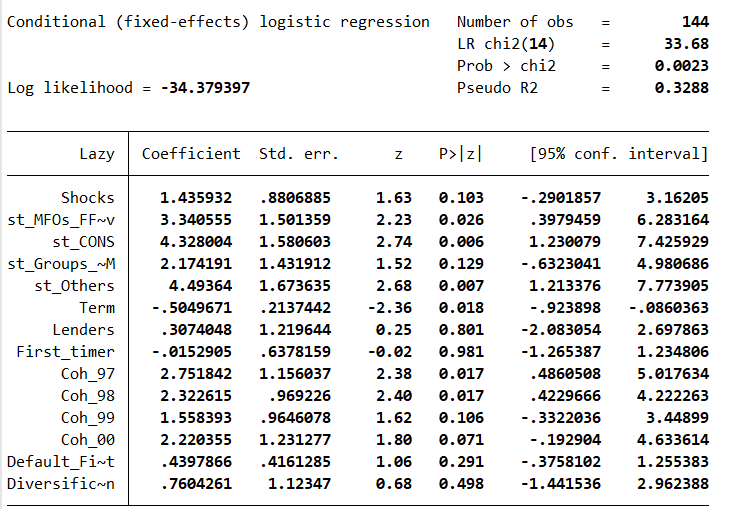

# Logit II - Version 4 - equivalent to Table 8.8 page 156.

Results from Stata using "xtlogit".  xtlogit takes into account correcly the panel structure of the data and therefore, the results below are the best estimates for the standard errors.

These results were obtained after running the following line:
version 9: xtlogit Lazy  a_Cbba a_El_Alto a_La_Paz a_Sta_Cruz Shocks Manufacture Commerce Services st_MFO st_CONS st_Groups  st_Others Term Lenders First_timer Coh_97-Coh_00 Default_First Pot1460 Age Education Diver Sav*  Migrants ,  nolog i(cuest) re 


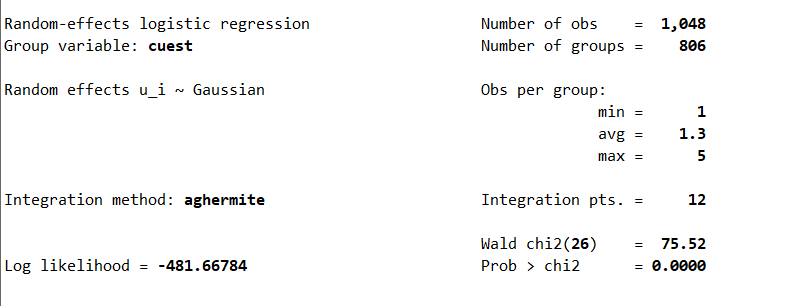

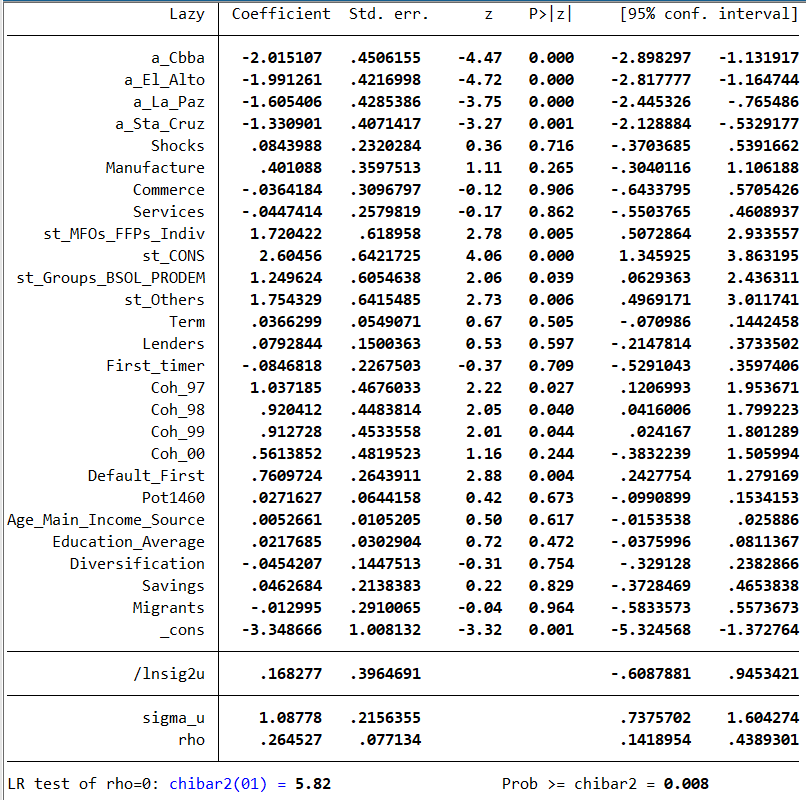

# Updates on January 13, 2022

-Fix typo in "Goal of this notebook"

-added 'six' to data_reduced on cell 103

In [127]:
#saving main dataframe for future use in other notebooks
data_reduced.to_pickle("data_reduced_from_wrangling.pkl")
data_reduced.to_csv("data_reduced_from_wrangling.csv", index=False)

In [128]:
from datetime import datetime
now = datetime.now()
print("Everything ran OK on:", now)

Everything ran OK on: 2022-01-13 11:21:08.664657
